## 银行卡卡号识别

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == 'bottom-to-top':
        reverse = True
        
    if method == "left-to-right" or method == 'top-to-bottom':
        i = 1
        
    boundingBoxes = [cv2.boundingRect(c) for c in cnts] # 用一个最小的矩形，把找到的形状包起来x,y,h,w
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    
    return cnts, boundingBoxes


def cv_show(img, name='img'):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [2]:
image_card = "src/img/card2.png"
template_temp = "src/img/temp.png"

FIRST_NUMBER = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card",
}

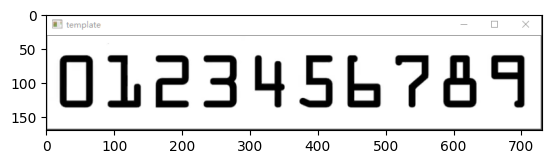

In [3]:
# 读取一个模版图像
img = cv2.imread(template_temp)
plt.imshow(img)

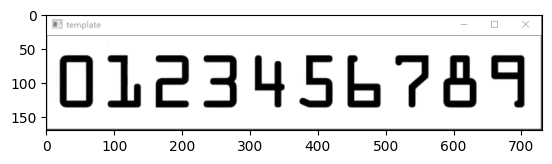

In [4]:
# 灰度图
ref = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(ref,cmap='gray')

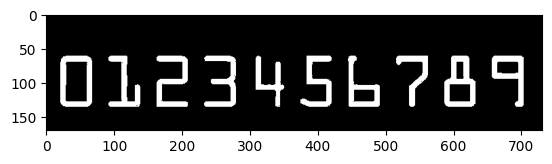

In [5]:
# 二值图像
ref = cv2.threshold(ref,10,255,cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref,cmap='gray')

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(10,)


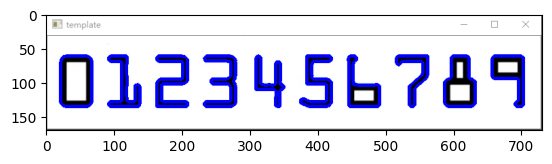

In [6]:
# 计算轮廓
refCnts, hierarchy = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img, refCnts, -1, (0, 0, 255), 3)
plt.imshow(img)
print(np.array(refCnts).shape)

refCnts = sort_contours(refCnts,  method='left-to-right')[0] # 排序，从左到右，从上到下


In [7]:
(x, y, w, h) = cv2.boundingRect(refCnts[0])
print((x, y, w, h))

(657, 61, 47, 75)


In [8]:
digits = {}

# 遍历每个轮廓
for (i, c) in enumerate(refCnts):
    # 计算外接矩阵并且resize成合适大小
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y+h,x:x+w]
    roi = cv2.resize(roi, (47 , 80))
    
    # 每个数字对应一个模版
    digits[i] = roi

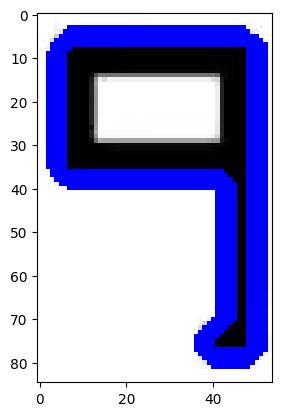

In [9]:
img_draw_rect = img.copy()
# cv2.rectangle(img_draw_rect, digits[0],  -1, (0, 0, 255), 3)
x2, y2 = refCnts[0][0][0]
plt.imshow(img_draw_rect[y2-5:y2+80,x2-7:x2+47])

In [10]:
# 初始化卷积核
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

ori_size: (393, 582, 3)
re_size: (196, 291, 3)


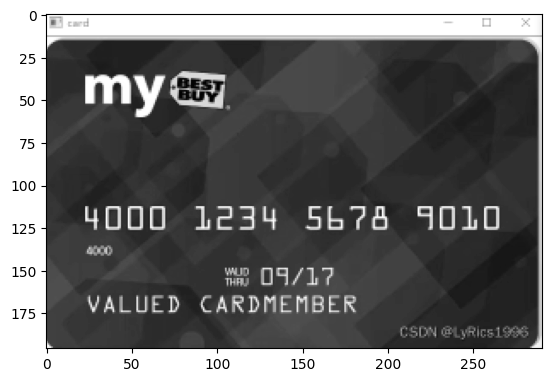

In [11]:
# 读取输入图像，预处理
image = cv2.imread(image_card)
print('ori_size:', image.shape)
image = cv2.resize(image, None,fy=0.5, fx=0.5)
print('re_size:', image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

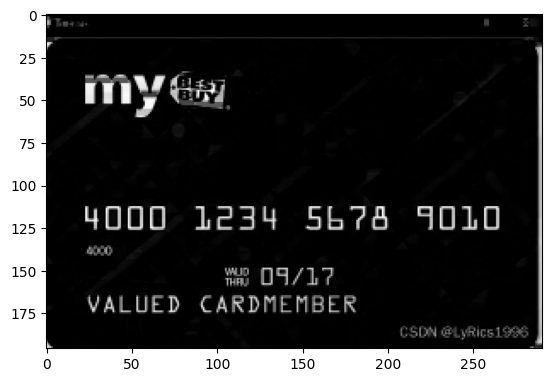

In [12]:
# 礼帽操作，突出更明亮的区域
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.imshow(tophat,cmap='gray')

(196, 291)


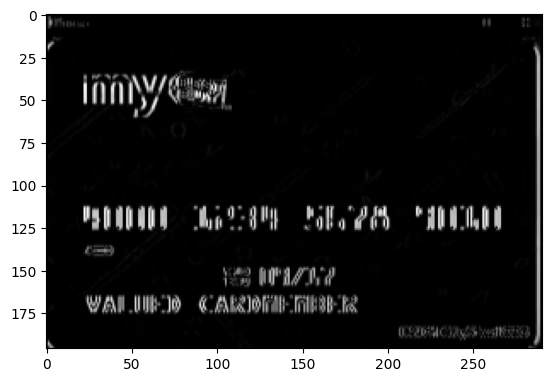

In [13]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1) # ksize=-1相当于3*3

gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype('uint8')

print(np.array(gradX).shape)
plt.imshow(gradX, cmap='gray')


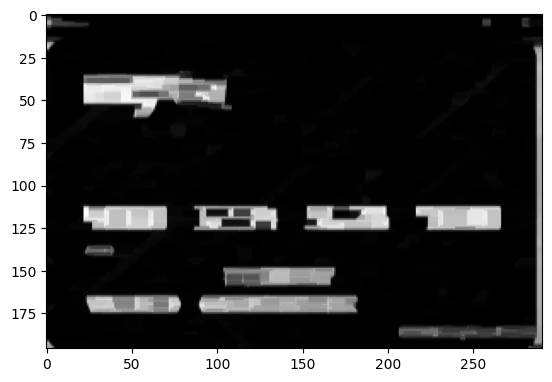

In [14]:
# 通过闭操作（先膨胀再腐蚀）将数字连在一起
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
plt.imshow(gradX, cmap='gray')

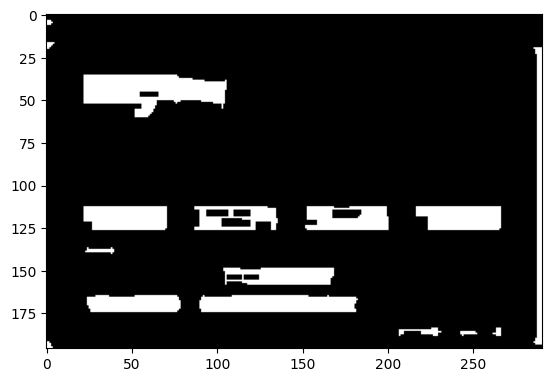

In [15]:
# THRESH_OTSU会自动寻找合适的阈值，适合双峰，需把阈值参数设置为0
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh, cmap='gray')

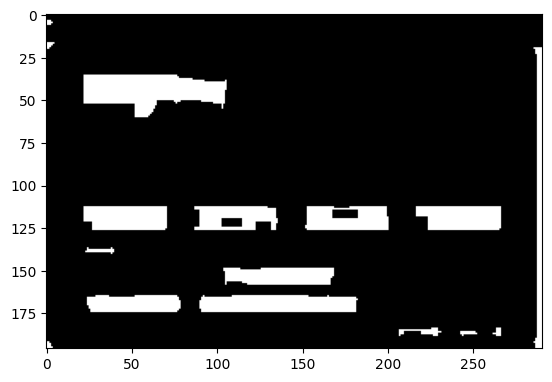

In [16]:
# 再来一个闭操作
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.imshow(thresh,cmap='gray')

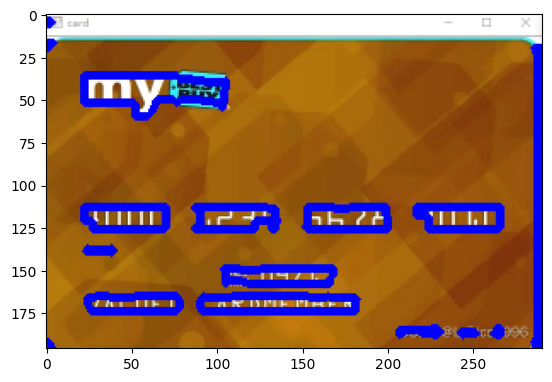

In [17]:
# 计算轮廓
threshCnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = threshCnts
cur_img = image.copy()
cv2.drawContours(cur_img, cnts, -1, (0,0,255), 3)
plt.imshow(cur_img)

In [18]:
locs = []
# 遍历轮廓
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    # print(f'i:{i},{x, y, w, h}')
    # 按照特定图像，选择合适的区域
    if ar > 2.5 and ar < 4:
        if (w > 40 and w< 55) and (h > 10 and h< 20):
            locs.append((x, y, w, h))   

# 将符合的轮廓从左到右排序
locs  =sorted(locs, key=lambda b: b[0])

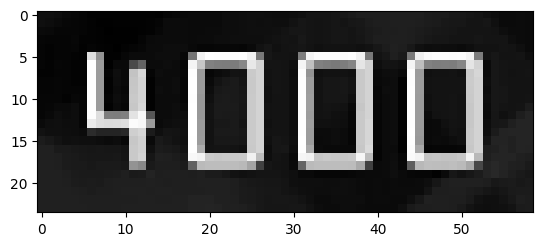

In [19]:
(gX, gY, gW, gH) = locs[0]
group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
plt.imshow(group,cmap='gray')

In [20]:
output = []
# 遍历轮廓中的每个数字
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    groupOutput = []
    # 根据坐标提取每个组
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    #预处理
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # cv_show(group)
    digitCnts, hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # digitCnts = sort_contours(digitCnts, method='right-to-left')[0]
    digitCnts  =sorted(digitCnts, key=lambda b: b[0][0][0])
    
    for c in digitCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        # 找到当前数值的轮廓，resize成合适的大小
        roi = group[y:y + h, x:x + w]
        roi  =cv2.resize(roi, (47, 80))
        # cv_show(roi)
        # 计算匹配得分
        scores = []
        
        # 在模版中计算每个得分
        for (digit, digitROI) in digits.items():
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
        
        # 得到最合适的数字
        groupOutput.append(str(np.argmax(scores)))
        
    # 画出来
    cv2.rectangle(image, (gX -5, gY - 5), (gX + gW + 5, gY + gH + 5), (0, 0, 255), 1)
    cv2.putText(image, ''.join(groupOutput), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0,0,255), 2)
    
    # 得到结果
    output.extend(groupOutput)  
    

5999876543210989


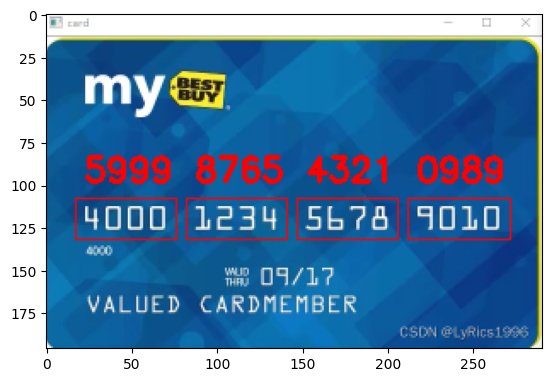

In [21]:
plt.imshow(image[...,::-1])
print(''.join(map(str, output)))

？怎么回事